## **FINM 32000 - HW7**

#### Yumeng Zhang (12372205)

I discussed with Yitong Li and Qianyu Pan.

### **Problem 1a**

Two of the functions have one or more places where you are to "FILL THIS IN"

In [22]:
import numpy as np
import scipy.optimize
import statsmodels.api as sm

In [23]:
class GBM:

    def __init__(self,S0,r,sigma):
        self.S0 = 1
        self.r = 0.03
        self.sigma = 0.20

In [24]:
hw7dynamics = GBM(S0=1,r=0.03,sigma=0.20)

In [25]:
class Put:
    
    def __init__(self,K,T):
        self.K = K
        self.T = T

In [26]:
hw7contract = Put(K=1.1,T=4) 

In [27]:
class MC:
    
    def __init__(self,M,N,seed,algorithm):
        
        self.M = M     # Number of paths  
        self.N = N     # Number of time periods  
        self.rng = np.random.default_rng(seed=seed) # Seeding the random number generator with a specified number helps make the calculations reproducible

        self.algorithm = algorithm   
        #'value' for Value-based approach (Longstaff-Schwartz) -- problem 1a
        #'policy' for Policy optimization -- problem 1b
    
    def price_americanPut_GBM(self,contract,dynamics):

        r=dynamics.r
        sigma=dynamics.sigma
        S0=dynamics.S0

        K=contract.K
        T=contract.T

        N=self.N
        M=self.M
        dt=T/N

        Z = self.rng.normal(size=(M,N))

        paths = S0*np.exp((r-sigma**2/2)*dt*np.tile(np.arange(1,N+1),(M,1))+sigma*np.sqrt(dt)*np.cumsum(Z,axis=1))

        payoffDiscounted = np.maximum(0,K-paths[:,-1])
        #This is the payoff (cashflow) along each path,
        #discounted to time nn (for nn=N,N-1,...)
        #It corresponds to the far right-hand column in each page of the
        #Excel worksheet
        #I'm initializing it for time nn=N.

        #You could make payoffDiscounted
        #to be a matrix because it depends on nn.
        #But I will just reuse a 1-dimensional array,
        #by overwriting the time nn+1 entries at time nn.        

        for nn in np.arange(N-1,0,-1):
            continuationPayoffDiscounted = np.exp(-r*dt)*payoffDiscounted
            # This is the CONTINUATION payoff (cashflow) along each path,
            # discounted to time nn (for nn=N-1,N-2,...)
            # It corresponds to the blue column in each page of the Excel worksheet
            # Note that payoffDiscounted comes from the previous iteration 
            # -- which was at time nn+1.  So now we discount back to time nn.

            X=paths[:,nn-1]               
            exerciseValue = K-X

            if self.algorithm == 'value': 
                # This is the value function (Longstaff-Schwartz) approach.  For problem 1a

                basisfunctions = np.column_stack((np.ones(M), X, X**2))
                # FILL THIS IN.  You may use np.stack
                # This will be an M-by-3 array containing the basis functions (Same ones as L7.9-7.10, and Excel)

                Y = continuationPayoffDiscounted[exerciseValue>0]
                X = basisfunctions[exerciseValue>0]
                model = sm.OLS(Y,X).fit()
                coefficients = model.params
                # FILL THIS IN  
                # This will be an array of 3 estimated "betas".

                estimatedContinuationValue = model.predict(basisfunctions)
                # FILL THIS IN with an array of length M. 
                # This is similar to the Red column in Excel

                whichPathsToExercise = (exerciseValue >= np.maximum(estimatedContinuationValue,0))
                #This is a length-M array of Booleans

            elif self.algorithm == 'policy':
                # This is the policy optimization approach to Reinforcement learning.  For problem 1b

                (a_opt,b_opt) = scipy.optimize.minimize(
                    negofMCaverageOfExpectedPayouts,(0,0),args=(X,exerciseValue,continuationPayoffDiscounted),method='Nelder-Mead').x
                    #Chose Nelder-Mead optimizer because it is generating reasonable results with minimal coding effort
                    #But gradient methods, done properly, usually run faster

                whichPathsToExercise = np.logical_and(softExercise(X, a_opt, b_opt) >= 0.5, exerciseValue > 0)
                    #FILL THIS IN, using the right-hand side of the last equation on the homework sheet 
                    #This obtains the hard exercise decision from the optimized soft exercise function
                    #It should be a length-M array of Booleans (as it was in the "value" approach.  
                    #But here it comes from the softExercise function)

            else:
                raise ValueError('Unknown algorithm type')


            payoffDiscounted[whichPathsToExercise] = exerciseValue[whichPathsToExercise]  
            # FILL THIS IN -- see the "discounted cashflow along path" column in Excel 
            payoffDiscounted[np.logical_not(whichPathsToExercise)] = continuationPayoffDiscounted[np.logical_not(whichPathsToExercise)] 
            # FILL THIS IN -- see the "discounted cashflow along path" column in Excel

        # The time-0 calculation needs no regression
        continuationPayoffDiscounted = np.exp(-r*dt)*payoffDiscounted;
        estimatedContinuationValue = np.mean(continuationPayoffDiscounted);
        putprice = max(K-S0,estimatedContinuationValue);

        return(putprice)
    

In [28]:
hw7MC = MC(M=10000,N=4,seed=0,algorithm='value')

In [29]:
hw7MC.price_americanPut_GBM(hw7contract,hw7dynamics)

0.16210625617317392

### **Problem 1b**

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# for Policy optimization approach, problem 1b
#
# If b<<0 then this function essentially returns nearly 1 if X<a, or nearly 0 if X>a
# but with some smoothing of the discontinuity, using a sigmoid function, to help the optimizer

def softExercise(X,a,b):
    return 1/(1+np.exp(-b*(X-a)))

In [32]:
# for Policy optimization approach, problem 1b

def negofMCaverageOfExpectedPayouts(coefficients, x, exercisePayoff, continuationPayoff):

    p = softExercise(x,*coefficients)    

    # p and exercisePayoff and continuationPayoff are all length-M arrays

    result = (-1)*np.mean(p * exercisePayoff + (1-p) * continuationPayoff)

    return result

## You fill in, what to return.  It should be the negative of the expression inside the max() on the homework sheet.
## Need to take the negative because we are calling "minimize" but we want to do _maximization_

In [33]:
hw7MC = MC(M=10000,N=4,seed=0,algorithm='policy')

In [34]:
hw7MC.price_americanPut_GBM(hw7contract,hw7dynamics)

0.16263529459015832

### **Problem 2**

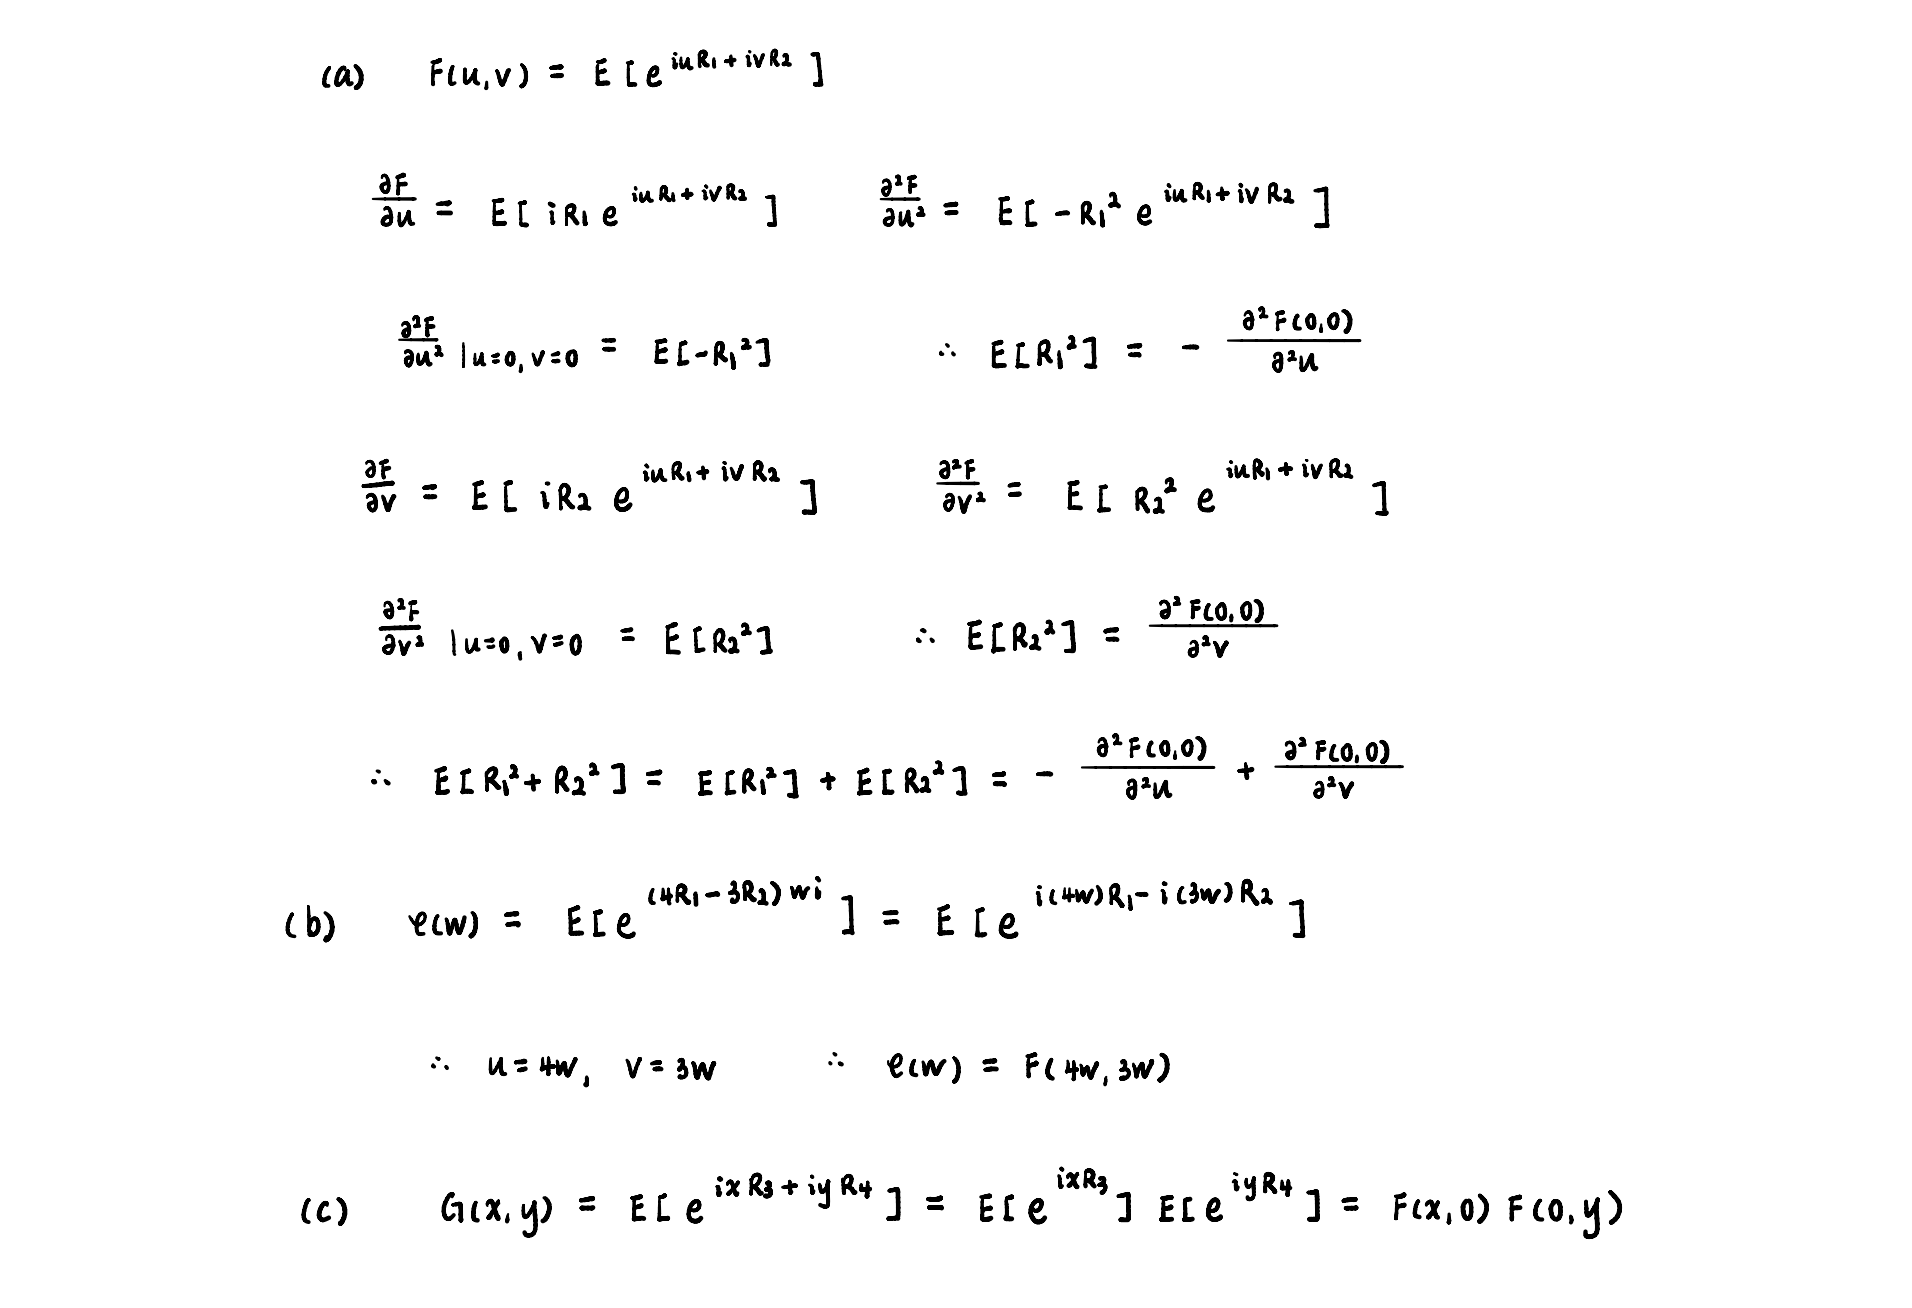